# Silatra CNN Trainer

The dataset was huge so in order to train, I used the Kaggel Kernels which provides access to NVidia K80 GPU with 16 GB RAM. 

With this I achieved an accuracy of 97.16% on validation set.

* This uses the latest tensorflow version 2.2

In [1]:
import tensorflow as tf
import keras
import os
import shutil
import cv2
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [3]:
img_path = '../input/indian-sign-language-translation-letters-n-digits/'

for class1 in os.listdir(img_path):
    num_images = len(os.listdir(os.path.join(img_path,class1)))
    for (n,filename) in enumerate(os.listdir(os.path.join(img_path,class1))):
        img = os.path.join(img_path,class1,filename)
        if not os.path.exists('test/'+class1+'/'):
            os.makedirs('test/'+class1+'/')
            os.makedirs('train/'+class1+'/')
            os.makedirs('val/'+class1+'/')
        if n < int(0.1 * num_images):
            shutil.copy(img,'test/'+class1+'/'+filename)
        elif n < int(0.8 * num_images):
            shutil.copy(img,'train/'+class1+'/'+filename)
        else:
            shutil.copy(img,'val/'+class1+'/'+filename)

In [4]:
def load_data(image_dir):
    images = []
    y = []
    classNum = 0
    for class1 in tqdm(os.listdir(image_dir)):
        for file_name in os.listdir(os.path.join(image_dir,class1)):
            images.append(cv2.imread(os.path.join(image_dir,class1,file_name)))
            y.append(classNum)
        classNum += 1
    print(f'Loaded {len(images)} images from {image_dir} directory')
    images = np.array(images)
    y = np.array(y)
    return images,y

In [5]:
_, _ = load_data('train/')
test_images,test_labels = load_data('test/')
_, _ = load_data('val/')

 12%|█▏        | 4/33 [00:00<00:01, 25.52it/s]

Loaded 7527 images from train/ directory


  6%|▌         | 2/33 [00:00<00:01, 16.14it/s]

Loaded 1074 images from test/ directory


100%|██████████| 33/33 [00:02<00:00, 11.10it/s]

Loaded 2151 images from val/ directory


In [6]:
arr = [i for i in range(10)] + [chr(ord('a')+i) for i in range(26)]
arr.remove('v')
arr.remove('h')
arr.remove('j')
label_dicts = {i:arr[i] for i in range(len(arr))}
label_dicts

{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'i',
 18: 'k',
 19: 'l',
 20: 'm',
 21: 'n',
 22: 'o',
 23: 'p',
 24: 'q',
 25: 'r',
 26: 's',
 27: 't',
 28: 'u',
 29: 'w',
 30: 'x',
 31: 'y',
 32: 'z'}

In [7]:
def show_samples(X,y,n=30):
    classes = np.unique(y)
    classNo = 0
    for class1 in classes:
        imgs = X[y == class1][:n]
        j = 10
        i = n // 10
        plt.figure(figsize=(15,1))
        for (c,img) in enumerate(imgs,1):
            plt.subplot(i,j,c)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.suptitle(f'Digit/Letter: {label_dicts[class1]}')
        classNo += 1
        if classNo == 15: 
            break

In [8]:
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.05,
        zoom_range=(0.8,1.2),
        width_shift_range=0.05,
        height_shift_range=0.05,
        rotation_range=30,
        brightness_range=(0.5,1.5),
        channel_shift_range=1,
        horizontal_flip=True)

train_generator = datagen.flow_from_directory(
        'train/',
        target_size=(224,224),
        batch_size=350,
        class_mode='categorical')
valid_generator = datagen.flow_from_directory(
        'val/',
        target_size=(224,224),
        batch_size=100,
        class_mode='categorical')
# plt.imshow(train_generator.next()[0].reshape(140,160,3))

Found 7527 images belonging to 33 classes.
Found 2151 images belonging to 33 classes.


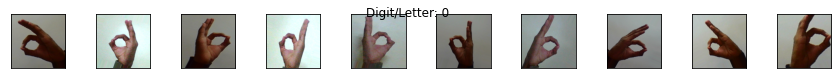

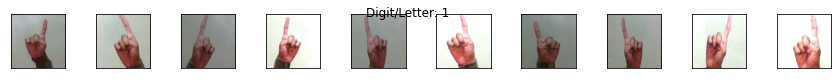

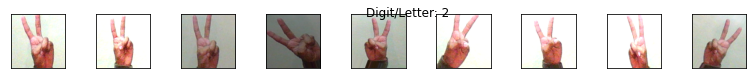

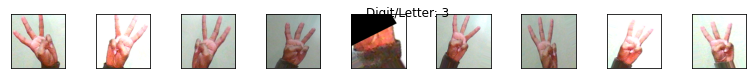

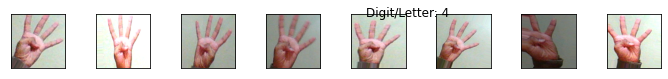

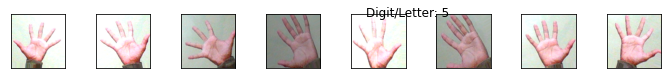

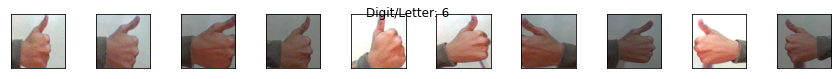

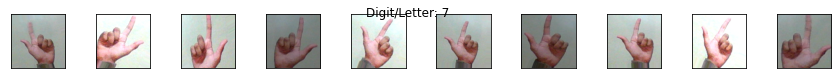

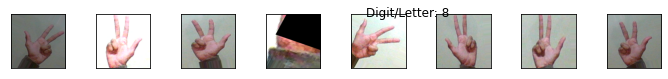

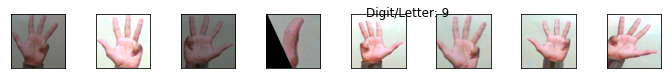

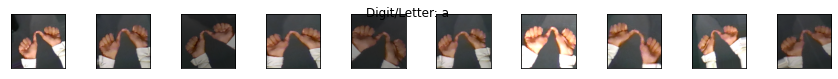

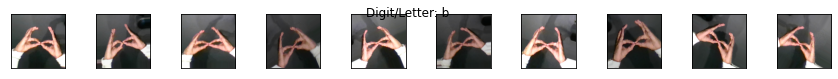

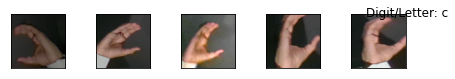

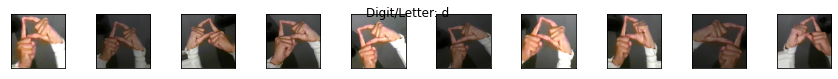

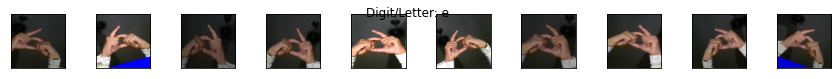

In [9]:
batch1 = train_generator.next()
show_samples(batch1[0], batch1[1].argmax(axis=1),n=10)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D

In [11]:
model = Sequential()

model.add(Conv2D(16,kernel_size=8,activation='relu',input_shape=(224,224,3),padding='same'))
model.add(MaxPooling2D(pool_size=(8,8),strides=(8,8),padding='same'))
model.add(Conv2D(32,kernel_size=3,activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(4,4),strides=(4,4),padding='same'))
model.add(Conv2D(64,kernel_size=3,activation='relu',padding='same'))
model.add(Flatten())
model.add(Dense(len(label_dicts),activation='softmax'))

In [12]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=8000,
    decay_rate=0.01)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
train_step_size = train_generator.n//train_generator.batch_size
val_step_size = valid_generator.n//valid_generator.batch_size
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_step_size,
        validation_data=valid_generator,
        validation_steps=val_step_size,
        epochs=15)

Train for 21 steps, validate for 21 steps
Epoch 1/15
21/21 [==============================] - 149s 7s/step - loss: 3.2903 - accuracy: 0.2030 - val_loss: 2.0207 - val_accuracy: 0.4133
Epoch 2/15
21/21 [==============================] - 145s 7s/step - loss: 1.3061 - accuracy: 0.6214 - val_loss: 0.8331 - val_accuracy: 0.7529
Epoch 3/15
21/21 [==============================] - 145s 7s/step - loss: 0.5691 - accuracy: 0.8210 - val_loss: 0.4719 - val_accuracy: 0.8686
Epoch 4/15
21/21 [==============================] - 145s 7s/step - loss: 0.3456 - accuracy: 0.8923 - val_loss: 0.3741 - val_accuracy: 0.8914
Epoch 5/15
21/21 [==============================] - 145s 7s/step - loss: 0.2578 - accuracy: 0.9211 - val_loss: 0.2688 - val_accuracy: 0.9210
Epoch 6/15
21/21 [==============================] - 143s 7s/step - loss: 0.2347 - accuracy: 0.9296 - val_loss: 0.2707 - val_accuracy: 0.9210
Epoch 7/15
21/21 [==============================] - 142s 7s/step - loss: 0.2197 - accuracy: 0.9313 - val_loss: 0

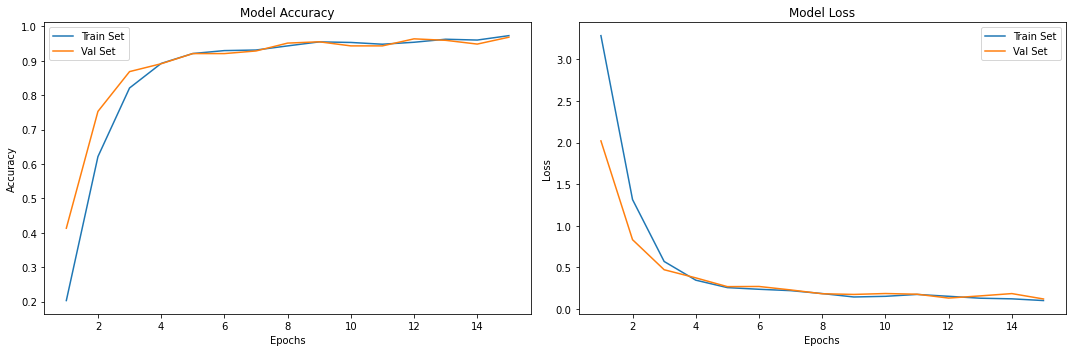

In [14]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [15]:
model.evaluate_generator(valid_generator)

[0.1245629827237942, 0.9716411]

In [16]:
model.save('Silatra_HandPoses_CNN_27May20.h5')

In [17]:
from tensorflow.keras.models import load_model
model = load_model('Silatra_HandPoses_CNN_27May20.h5')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      3088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 33)                1